In [3]:
import os.path
import numpy as np

#Ensures we use Tensorflow 1.x
#%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_addons as tfa
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

import pandas as pd
from sklearn.linear_model import LinearRegression
from astropy.stats import median_absolute_deviation
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge

2.0.0


In [4]:
print(tf.__version__)
import tensorflow_addons as tfa

2.0.0


In [5]:
# rv_net imports.
import sys
sys.path.append("rv_net/")
from ops import training
from tf_util import config_util
from tf_util import configdict
from tf_util import estimator_runner
from rv_net import data_HARPS_N
from rv_net import  data, rv_model, estimator_util, load_dataset_ridge, ridge_regress_harps

In [6]:
# @title Residual plotting code
import matplotlib.pylab as mpl
def residual_plot(rv_list, x_axis, ccfs_of_interest, num_ref_ccf, plot_title):
    # create color scheme
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)

    # Create the residual plot by looping through the list of CCFs ordered by date
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    num = 0
    for i in np.arange(0, len(ccfs_of_interest)):
        if num_ref_ccf == "median":
            plt.plot(x_axis, ccfs_of_interest[i] - np.median(list(ccfs_of_interest), axis=0), color=colors[num])
        else:
            if i != num_ref_ccf:
                plt.plot(x_axis, ccfs_of_interest[i] - ccfs_of_interest[num_ref_ccf], color=colors[num])
        num += 1

    plt.title(plot_title)
    # make color bar
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=(min_rv - np.median(rv_list)), vmax=(max_rv - np.median(rv_list)))
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="vertical", pad=-0.0001)
    cb.set_label(label='Stellar Activity Signal (m/s)', size=16, rotation=270, labelpad=20)

## Reading in the data

In [7]:
eval_method ='cross_val' # "val"#"cross_val" # "val" # "test"

ccf_len = 46

In [8]:
# Change this path to point towards the location of the files in your drive

!ls 'TF_records_Nov2021'

TF_ccf_cross_val0 TF_ccf_cross_val4 TF_ccf_cross_val8 TF_ccf_val
TF_ccf_cross_val1 TF_ccf_cross_val5 TF_ccf_cross_val9
TF_ccf_cross_val2 TF_ccf_cross_val6 TF_ccf_full_train
TF_ccf_cross_val3 TF_ccf_cross_val7 TF_ccf_test


In [9]:
# Read in files for cross-validation
DATA_DIR = 'TF_records_Nov2021/' #TF_record_July_10_21_no_planets_median_prov_rvs/' #HARPS-N Solar Telescope Data (using old DRS)/' #TF_record_July_10_21_no_planets_same_test_set' #TF_record_July_10_21_no_planets_v2'

if eval_method =="cross_val":
  data_files = tf.data.Dataset.list_files(DATA_DIR+'*cross_val*',shuffle=False)
  data_files = [t.numpy() for t in data_files]
  TRAIN_FILE_NAME_LIST = []
  VAL_FILE_NAME_LIST = []

  N = len(data_files)
  for i in range(N):
    val_files = [data_files[i]]
    #print(val_files)
    VAL_FILE_NAME_LIST.append(val_files)
    train_files = data_files[0:i] + data_files[i+1:]
    TRAIN_FILE_NAME_LIST.append(train_files)
    # add all the training files

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 51

elif eval_method =="val":
  TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
  VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_val")]]#test")]]

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 61
elif eval_method =="test":
  TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
  VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_test")]]#test")]]

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 61
else:
  print("Please select a valid evaluation method: 'cross_val' or 'val' or 'test'")

2021-12-06 15:29:13.934341: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 15:29:13.938164: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [10]:
print(TRAIN_FILE_NAME_LIST)
VAL_FILE_NAME_LIST

[[b'TF_records_Nov2021/TF_ccf_cross_val1', b'TF_records_Nov2021/TF_ccf_cross_val2', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_records_Nov2021/TF_ccf_cross_val7', b'TF_records_Nov2021/TF_ccf_cross_val8', b'TF_records_Nov2021/TF_ccf_cross_val9'], [b'TF_records_Nov2021/TF_ccf_cross_val0', b'TF_records_Nov2021/TF_ccf_cross_val2', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_records_Nov2021/TF_ccf_cross_val7', b'TF_records_Nov2021/TF_ccf_cross_val8', b'TF_records_Nov2021/TF_ccf_cross_val9'], [b'TF_records_Nov2021/TF_ccf_cross_val0', b'TF_records_Nov2021/TF_ccf_cross_val1', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_recor

[[b'TF_records_Nov2021/TF_ccf_cross_val0'],
 [b'TF_records_Nov2021/TF_ccf_cross_val1'],
 [b'TF_records_Nov2021/TF_ccf_cross_val2'],
 [b'TF_records_Nov2021/TF_ccf_cross_val3'],
 [b'TF_records_Nov2021/TF_ccf_cross_val4'],
 [b'TF_records_Nov2021/TF_ccf_cross_val5'],
 [b'TF_records_Nov2021/TF_ccf_cross_val6'],
 [b'TF_records_Nov2021/TF_ccf_cross_val7'],
 [b'TF_records_Nov2021/TF_ccf_cross_val8'],
 [b'TF_records_Nov2021/TF_ccf_cross_val9']]

In [11]:
def _example_parser(serialized_example):
    """Parses a single tf.Example into feature and label tensors."""
    feature_name = "Rescaled CCF_residuals_cutoff"#"Rescaled CCF_residuals" #CCF_residuals
    label_name = "activity signal"#"RV",
    label2_name = "BJD"
    data_fields = {
        feature_name: tf.io.FixedLenFeature([ccf_len], tf.float32), #[161], tf.float32),
        label_name: tf.io.FixedLenFeature([], tf.float32),
        label2_name: tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
    return parsed_fields[feature_name], parsed_fields[label_name]*1000, parsed_fields[label2_name]

#def load_dataset(file_pattern, batch_size, mode=tf.estimator.ModeKeys.EVAL):
#  filename_dataset = tf.data.Dataset.list_files(file_pattern)
#  dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
#  if mode == tf.estimator.ModeKeys.TRAIN:
#    dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
#  dataset = dataset.map(_example_parser, num_parallel_calls=4)
#  dataset = dataset.batch(batch_size)
#  return dataset

def load_dataset(filenames, batch_size, mode=tf.estimator.ModeKeys.EVAL):
    filename_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
    dataset = dataset.map(_example_parser, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)
    return dataset

In [12]:
# @title Define LinearModel, FCModel, CNNModel
class LinearModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(LinearModel, self).__init__()
        self.hparams = hparams
        #self.weights = tf.Variable(tf.zeros(self.hparams.num_features))
        self.dense_layer = tf.keras.layers.Dense(
            1, kernel_initializer=tf.zeros_initializer, use_bias=False)
        
    def call(self, features, training=False):
      # return tf.tensordot(features, self.weights, axes=1)
      return tf.squeeze(self.dense_layer(features))

class FCModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(FCModel, self).__init__()
        self.hparams = hparams
        #self.hidden_layer1 = tf.keras.layers.Dense(
        #    self.hparams.num_dense_units, activation=tf.keras.activations.relu)
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

# @title Define RVLinearModel
class CNNModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(CNNModel, self).__init__()
        self.hparams = hparams
        self.conv_layers = [
          tf.keras.layers.Conv1D(
              filters=hparams.num_conv_filters, 
              kernel_size=hparams.conv_kernel_size,
              activation=tf.keras.activations.relu,
              padding="same")
          for i in range(hparams.num_conv_layers)
        ]
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      for conv in self.conv_layers:
        net = conv(net)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

In [13]:
def make_predictions(model, dataset):
  all_preds = []
  all_labels = []
  all_bjds = []
  for features, labels, bjds in dataset:
    preds = model(features, training=False)
    all_preds.append(preds.numpy())
    all_labels.append(labels.numpy())
    all_bjds.append(bjds.numpy())
  return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

def train(model, hparams, plots, model_name, num_epochs):#=100):
  train_dataset = load_dataset([TRAIN_FILE_NAME], batch_size=hparams.batch_size, mode=tf.estimator.ModeKeys.TRAIN)
  val_dataset = load_dataset([VAL_FILE_NAME], batch_size=min(1024, NUM_VALIDATION_EXAMPLES), mode=tf.estimator.ModeKeys.EVAL)
  loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
  optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
  metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
  ]
  weight_decay_list_t.append(hparams.weight_decay)
  gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

  metric_values = []
  for epoch in range(1, num_epochs+1):
    # Reset metric values for each new epoch.
    for m in metrics:
      m.reset_states()

    # Train over all batches in the training set.
    for features, labels, bjds in train_dataset:
      if hparams.gaussian_noise_scale:
        features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
        #print(hparams.gaussian_noise_scale)
      # One training step.
      with tf.GradientTape() as t:
        preds = model(features, training=True)
        loss = loss_fn(labels, preds)
      grads = t.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # Update the metrics.
      for m in metrics:
        m(labels, preds)
    
    # End of an epoch.
    epoch_metrics = {"epoch": epoch}
    # First, log the training metrics.
    for m in metrics:
      epoch_metrics[m.name] = m.result().numpy()
    # Next, evaluate over the validation set.
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
    # Add a metric for the raw scatter started with
    epoch_metrics["original_rmse"] = np.std(labels_val)
    # Add a metric for raw scatter - corrected scatter
    epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
    # Log metrics to tensorboard.
    for metric, value in epoch_metrics.items():
      tf.summary.scalar(metric, value, step=epoch)
    epoch_metrics["epoch"] = epoch
    # Print metric values at selected epochs.
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
      print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
    metric_values.append(epoch_metrics)

  # Gather predictions
  labels, preds, bjd = make_predictions(model, train_dataset)
  labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
  all_bjds_val.append(bjd_val)
  bjd_run_val.append(bjd_val)
  all_pred_val.append(preds_val)
  pred_run_val.append(preds_val)
  all_labels_val.append(labels_val)
  labels_run_val.append(labels_val)

  # Scatter reduction plot
  sd_x = np.std(labels_val, ddof=1)
  rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
  rms_x_list.append(rms_x)
  rms_avg_list.append(rms_x)
  stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
  x_range = np.linspace(-4,5.5, 17)
  upper_bound = x_range+rms_x
  lower_bound = x_range-rms_x

  if plots=="ON":
    fig, axes = plt.subplots(1, 2, figsize=(24, 6))
    ax = axes[0]
    ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
    ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")

    # Gather predictions to plot against labels.
    ax = axes[1]
    ax.plot(preds, labels, ".", label="Training")
    ax.plot(preds_val, labels_val, ".", label="Validation")
    ax.set_xlabel("Actual Y")
    ax.set_ylabel("Predicted Y")
    ax.legend(loc="lower right")

    # plot the scatter reduction plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(labels_val, preds_val, ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 4);
    ax1.set_ylim(-4, 4);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")
  else:
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    print(textstr)
    
  return metric_values

# Ridge Regression

In [14]:
class DatasetBuilder(object):
    """Dataset builder class."""

    def __init__(self, file_pattern, hparams, mode, ccf_len, repeat=1):
        """Initializes the dataset builder.
        Args:
          file_pattern: File pattern matching input file shards, e.g.
            "/tmp/train-?????-of-00100".
          hparams: A ConfigDict.
          mode: A tf.estimator.ModeKeys.
          repeat: The number of times to repeat the dataset. If None, the dataset
            will repeat indefinitely.
        """
        valid_modes = [
            tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL,
            tf.estimator.ModeKeys.PREDICT
        ]
        if mode not in valid_modes:
            raise ValueError("Expected mode in {}. Got: {}".format(valid_modes, mode))

        self.file_pattern = file_pattern
        self.hparams = hparams
        self.mode = mode
        self.repeat = repeat
        self.ccf_len = ccf_len

    def __call__(self):
        is_training = self.mode == tf.estimator.ModeKeys.TRAIN

        # Dataset of file names.
        filename_dataset = tf.data.Dataset.list_files(self.file_pattern,
                                                      shuffle=is_training)

        # Dataset of serialized tf.Examples.
        dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)

        # Shuffle in training mode.
        if is_training:
            dataset = dataset.shuffle(self.hparams.shuffle_values_buffer)

        # Possibly repeat.
        if self.repeat != 1:
            dataset = dataset.repeat(self.repeat)

        def _example_parser(serialized_example):
            """Parses a single tf.Example into feature and label tensors."""
            data_fields = {
                self.hparams.ccf_feature_name: tf.io.FixedLenFeature([self.ccf_len], tf.float32),
                self.hparams.label_feature_name: tf.io.FixedLenFeature([], tf.float32),
                self.hparams.label_feature_name2: tf.io.FixedLenFeature([], tf.float32),
            }
            parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
            ccf_data = parsed_fields[self.hparams.ccf_feature_name]
            label = parsed_fields[self.hparams.label_feature_name]
            label *= self.hparams.label_rescale_factor  # Rescale the label.
            label2 = parsed_fields[self.hparams.label_feature_name2]
            return {
                "ccf_data": ccf_data,
                "label": label,
                "bjd": label2,
            }

        # Map the parser over the dataset.
        dataset = dataset.map(_example_parser, num_parallel_calls=4)

        # Batch results by up to batch_size.
        dataset = dataset.batch(self.hparams.batch_size)

        # Prefetch a few batches.
        dataset = dataset.prefetch(10)

        return dataset

In [15]:
def load_dataset_ridge(filename, ccf_len):
  dataset_hparams = configdict.ConfigDict(dict(
    ccf_feature_name='Rescaled CCF_residuals_cutoff',#"Rescaled CCF_residuals", #CCF_residuals
    label_feature_name= "activity signal",#"RV",
    label_feature_name2= "BJD",
    batch_size=300,
    label_rescale_factor=1000,
  ))
  dataset = DatasetBuilder(filename, dataset_hparams, tf.estimator.ModeKeys.EVAL, ccf_len)()
  batches = list(dataset)
  ccf_data, labels, bjds = zip(*[(batch["ccf_data"], batch["label"], batch["bjd"]) for batch in batches])
  ccf_data = np.concatenate(ccf_data)
  labels = np.concatenate(labels)
  bjds = np.concatenate(bjds)
  assert len(ccf_data.shape) == 2
  assert len(labels.shape) == 1
  assert len(bjds.shape) == 1
  assert ccf_data.shape[0] == labels.shape[0]
  #print("Read dataset with {} examples".format(labels.shape[0]))
  return ccf_data, labels, bjds

In [16]:
def ridge_regress_harps(TRAIN_FILE_NAME_LIST, VAL_FILE_NAME_LIST, alpha, verbose, ccf_len):
  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []
  avg_list = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, ccf_len)
    val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, ccf_len)

    pred_run_val = []
    labels_run_val = []
    bjd_run_val = []
    for k in range(0,10):
      model = Ridge(alpha=alpha).fit(train_X, train_Y)
      val_pred_Y = model.predict(val_X)
      pred_run_val.append(val_pred_Y)
      labels_run_val.append(val_Y)
      bjd_run_val.append(val_bjd)
      rms_avg = np.sqrt(np.mean(np.square(val_Y -val_pred_Y)))
      rms_avg_list.append(rms_avg)
      if verbose == True:
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
        print("rms: "+str(rms_avg))
      else:
        continue
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  avg_list.append(avg)
  print("________________________")
  print("average rms = "+str(avg)+" m/s")

  #flatten the lists
  all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
  all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
  all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]
  
  return all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_list, alpha

In [17]:
# Cross validation Ridge Regression Model Run (10 times)

all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_rms_list, alpha = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                 VAL_FILE_NAME_LIST, 
                                                                                 alpha=3.6094,#340.010636,#9.469, #340.010636,	#335.734079,#9.469, 
                                                                                 verbose=False,
                                                                                 ccf_len = 46)

________________________
average rms = 1.0802236 m/s


labels: sd: 1.8284893224673766
corrected rv: sd: 1.0849636105498959
____________________________________________
labels: MAD*1.4826: 1.7439013288736342
corrected rv: MAD*1.4826: 1.0854544334962963
____________________________________________
labels: 68 percent/2: 1.7452755212783813
corrected rv: 68 percent/2: 1.0970001339912414


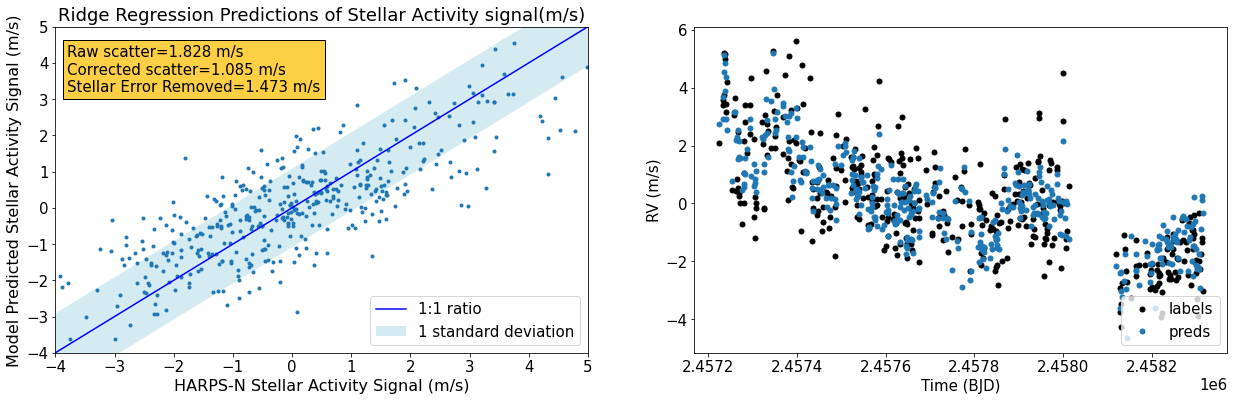

In [18]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_ridge_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("Ridge Regression Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (sd_labels, ),
    r'Corrected scatter=%.3f m/s' % (sd_corrected_rv, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 4.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

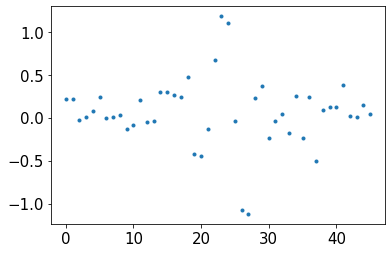

In [21]:
index=0
TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, 46)
val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, 46)
model = Ridge(alpha=alpha).fit(train_X, train_Y)
plt.plot(model.coef_, ".")
plt.ylabel("Weight")
plt.xlabel("")